In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
# 모델이 각 epoch마다 처리되는 상황을 보여줌
from tqdm import tqdm
from keras.layers import Input
# Modle : 멀티 모델 생성 클래스
# Sequential : 일반 모델 생성 클래스
from keras.models import Model, Sequential
# Dense : 훈련에 참여하는 은닉층, 츌력층 생성 클래스
# Dropout : 훈련에 참여하지 않는 전처리 계층
from keras.layers.core import Dense, Dropout
# advanced_activations : 활성화 객체 정의
# LeakyReLU : 일반적인 relu와 동일(sigmoid 개선 객체) / 0보다 작으면 0으로 크면 1로 반환
from keras.layers.advanced_activations import LeakyReLU
# 케라스에서 제공해주는 데이터셋 사용
# mnist : 0~9까지의 단일 숫자 이미지 데이터
from keras.datasets import mnist
# 모델 설정 시 사용할 손실율 계산 클래스
# GAN에서 성능이 좋은 Adam 사용
from tensorflow.keras.optimizers import Adam
# 케라스 초기화 클래스
from keras import initializers

In [8]:
# keras가 tensorflow를 백엔드로 사용할 수 있도록 지정
# 텐서 버전이 2.0보다 작은경우에는 아래 정의해야하며 2.0이상인 버전에서는 안해도 되지만 간혹 오류나는경우 있어 해주는것이 좋음
os.environ["KERAS_BAKEND"] = "tensorflow"

In [9]:
# 훈련을 재현할 때 동일한 결과를 얻을 수 있도록 한다. seed내 숫자는 의미없음
# 넘파이가 숫자값으로 랜덤한 값들의 패턴을 만들어서 제공해준다
np.random.seed(10)

In [10]:
# 가짜 이미지 생성에 사용할 노이즈 값
# 랜덤한 노이즈 데이터(벡터)의 차원 값을 설정함
# 밑에서 가짜 이미지 생성시 사용되는 변수
random_dim = 100

In [15]:
# 수집하기
# 사용변수 
# 훈련 데이터 : x_train, y_train
# 테스트 데이터 : x_test, y_test
(x_train, y_train),(x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [18]:
# 정규화
# 데이터를 픽셀 최대값인 255의 절반 값을 사용
# -1~1사이 값으로 만든다
# 생성기의 출력층에 사용하는 활성화 함수를 탄젠트를 사용해 -1~1값으로 출력
x_train = (x_train.astype(np.float32) - 125.5) / 127.5
x_train.shape

(60000, 28, 28)

In [19]:
# 사용되는 픽셀의 너비, 높이 2차원 데이터를 1차원으로 만들기 -> 너비 * 높이
x_train = x_train.reshape(60000, 28*28)
x_train.shape

(60000, 784)

In [24]:
# Generator(생성기) 모델 생성
generator = Sequential()

# 계층추가
# stddev : 랜덤한 난수 값 생성(표준편차 값)
# 계층 초기값 설정 : kernel_initializer
# input_dim : 입력차원 
# 246 : 뉴런(출력) 개수
generator.add(Dense(256, input_dim=random_dim,
                   kernel_initializer=initializers.RandomNormal(stddev=0.02)))
# relu 계층 추가
generator.add(LeakyReLU(0.2))

# upsample : 뉴런의 개수 증가 시키기
# 진짜같은 이미지르 만들기 위해 가중치 증가시킴
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

# 최종 출력층 생성
# tanh : 탄젠트 알고리즘(-1~1의 범위 값으로 출력)
# 최종 뉴런은 원본의 픽셀 개수로 원상복귀
generator.add(Dense(784, activation="tanh"))

In [28]:
# 모델생성하기
discriminator = Sequential()
# 사용되는 뉴런의 개수는 생성할 때 반대로 진행
discriminator.add(Dense(1024, input_dim=784,
                       kernel_initializer=initializers.RandomNormal(stddev=0.02)))
# relu 계층 추가
# 0인 값을 다음 계층으로 넘기는 경우 모든 뉴런들의 출력값이 0으로 되는 현상을 막기위해
# relu를 개선된 LeaktReLU 계층이 만들어졌음
# 0이 아닌 음수의 값을 생성해 넘길 수 있는 방법을 이용해 음수의 값 일부만 넘길 수 있도록 처리하기 위한 방법
# 0.2 = 20%의 음수값을 다음 계층으로 넘기기 위한 방법
discriminator.add(LeakyReLU(0.2))

# 전처리 계층 사용 : 일부 데이터를 사용 못하게 처리
discriminator.add(Dropout(0.3))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

# 최종 출력층 추가
discriminator.add(Dense(1, activation="sigmoid"))

In [29]:
# 모델 설정 : 옵티마이저 adam 정의
# learning_rate : 학습률(보폭)
# beta_1 : 방향과 보폭을 모두 적당하게 유지시키는 속성, 최적화 속성
optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)

In [30]:
# 두개 모델에 컴파일 해주기
generator.compile(optimizer=optimizer,
                 loss="binary_crossentropy")
discriminator.compile(optimizer=optimizer,
                 loss="binary_crossentropy")

In [49]:
# 두개 모델을 동시에 학습시키고 싶을 때 
# trainable 값을 False로 설정
# 판별기에서 생성기의 데이터와 자기 자신의 데이터를 비교
discriminator.trainable = False

# GAN 멀티모델 생성을 위한 입력데이터 생성
# 생성기와 판별기의 초기값과 동일한 차원 사용
gan_input = Input(shape=random_dim,)

# Genoerator()에 초기값을 넘긴 후
# 최종 결과 값을 얻어와야함
# 생성기의 최종 결과값은 = 이미지
x = generator(gan_input)

# 판별기 함수()에 생성기의 결과 이미지 테이터를 넘기기
# 판별기는 진짜/가짜만 판별함
# 판별기의 최종 결과 값은 = 확률로 알려줌
gan_output = discriminator(x)

# GAN 모델 생성 : 멀티모델
# 멀티 모델 생성 방법 : 입력과 출력 데이터를 넘겨주면 됨
# 입력이 2개(input, output)인 계층을 동시에 사용하게 됨
# 전이학습에서 사용되는 개념
# 기존의 데이터 가중치를 활용해 앞으로도 계속 upgrade사용
gan = Model(inputs = gan_input, outputs = gan_output)

# GAN 모델도 컴파일
gan.compile(optimizer=optimizer,
           loss="binary_crossentropy")

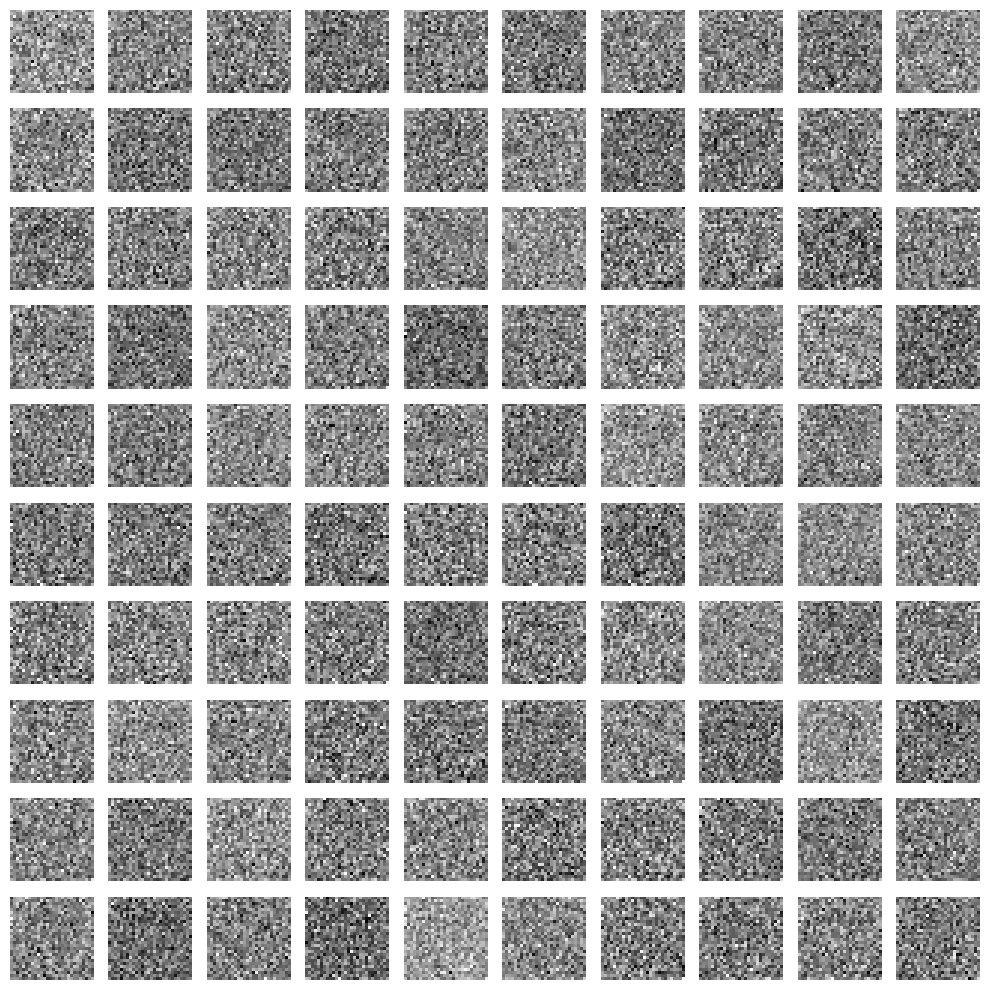

In [57]:
epoch = 0
examples = 100
dim = (10,10)
# 너비, 높이
figsize = (10,10)

# 랜덤한 2차원 데이터 생성
# 0~1사이 값으로
# size(100행, 100열)로 데이터 랜덤하게 생성
noise = np.random.normal(0,1,size=[examples, random_dim])

# 생성기를 통해 랜덤한 데이터를 전달해 이미지 데이터 생성
# 결과값 : 이미지 데이터
generated_images = generator.predict(noise)

# 이미지로 보여주기 위해 3차원 데이터로 만들기
generated_images = generated_images.reshape(examples,28,28)

# 그림그리기
plt.figure(figsize=figsize)

# for문 100번 반복
for i in range(generated_images.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)
    plt.imshow(generated_images[i],
              interpolation="nearest",
              cmap="gray_r")
    plt.axis("off")
plt.tight_layout()
plt.savefig("./01_images/gan_generated_image_epoch_{}.png".format(epoch))

--------------- Epoch 0 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.23it/s]


--------------- Epoch 1 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.73it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.77it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.00it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.96it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.31it/s]


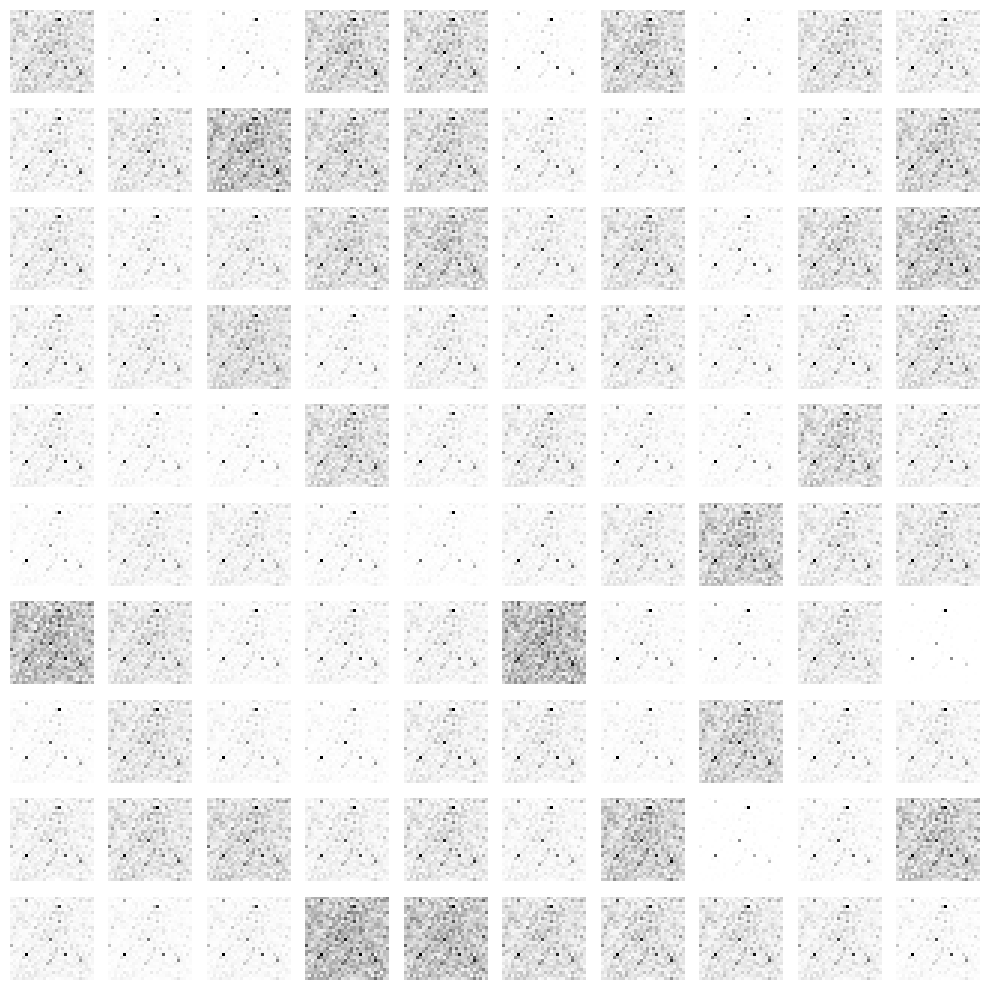

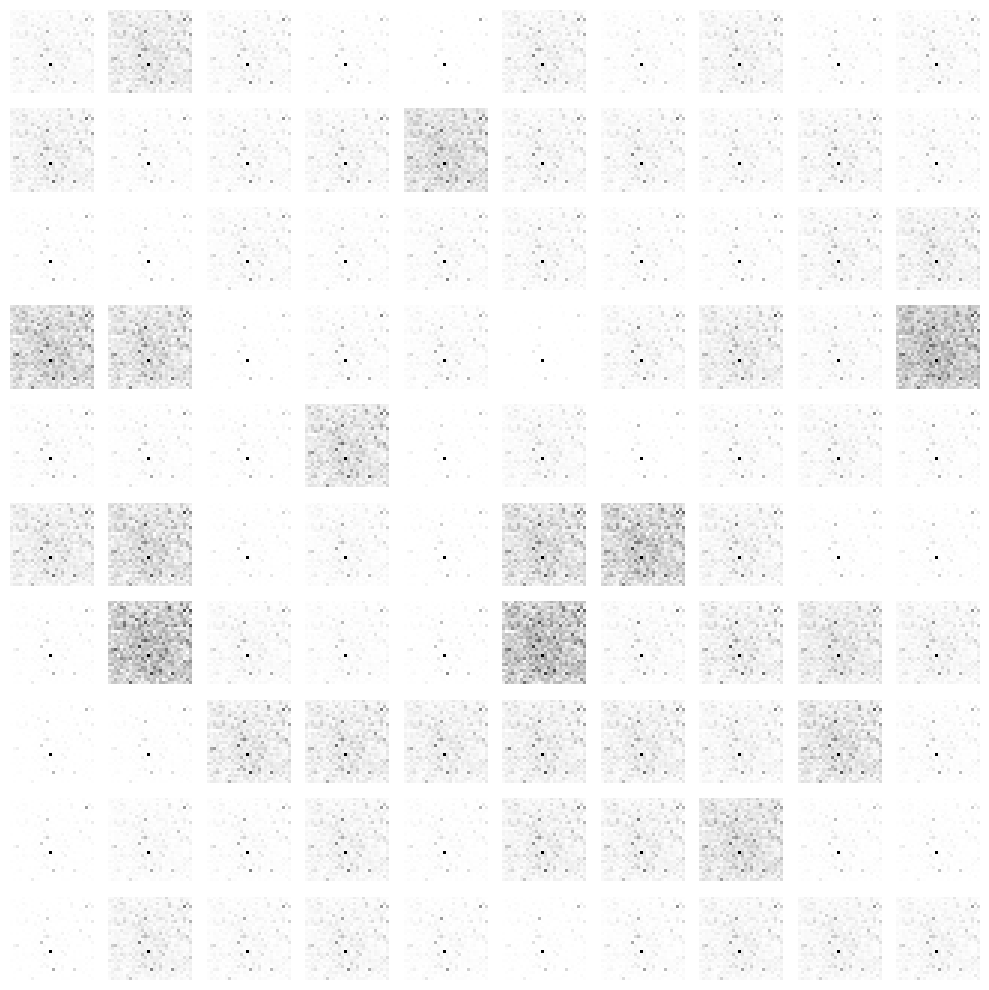

In [66]:
epochs = 5
batch_size =128
# load_mnist_data() 함수 호출 부분
# 데이터 읽어 들이는 부분(위에 정의만 해 놓음)
#(x_train, y_train),(x_test, y_test) = mnist.load_data()
#x_train, y_train, x_test, y_test = load_mnist_data()

# batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 설정
# train 데이터를 128사이즈의 batch로 나눔
batch_count = x_train.shape[0] // batch_size

# Generator 및 Disriminator 멀티 Gan모델 및 계층 생성 (정의만 해놓음)
# 이후 함수 호출로 사용

# 훈련시키기
for e in range(epochs+1):
    print("-"*15, "Epoch {}".format(e),"-"*15)
    
    # 훈련 진행 상태 확인(tqdm() 사용)
    for _ in tqdm(range(batch_count)):
        # 입력으로 사용할 랜덤한 노이즈 생성
        noise = np.random.normal(0,1,
                                size=[batch_size, random_dim])
        image_batch = x_train[np.random.randint(0,
                                               x_train.shape[0],
                                               size=batch_size)]
        
        # MNIST 이미지 생성하기 : Generator 사용
        # 예측 함수 실행해 아미지 데이터 얻기
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])
        
        # np.zeros() : 0으로 채워진 1차원 배열
        y_dis = np.zeros(2 * batch_size)
        y_dis[ : batch_size] = 0.9
        
        # Discriminator 학습시키기
        # classification layer를 학숩한 뒤
        # 결과값을 이용해 다시 feature map과 classification layer를 합쳐서
        # 전체 layer를 다시 학습하고자 할 때 True로 설정
        # 최초에는 feature map이 랜덤값을 사용하게 되지만
        # 학습 이후 이전의weight값을 이용할 수 있도록 한다(전이학습 개념)
        discriminator.trainable = True
        
        # train_on_batch()
        # 이미 존재하는 모델에 새로운 학습 데이터셋을 받아 이전의 모델이 학습한 가중치의 값으로 학습시킬 수 있도록하는 장점 활용
        # GAN은 기존 이미지의 가중치 값을 그대로 이용해 향상시키기 때문
        discriminator.train_on_batch(X, y_dis)
        
        # Generator 학습
        noise = np.random.normal(0.1,
                                size=[batch_size,random_dim])
        # ones() : 1로 배열 생성
        y_gen = np.ones(batch_size)
        
        # discriminator의 기능을 다시 멀티 모델 수행방식으로 설정
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)
    # 시각화하는 성능을 고려해 최초 1회 이후부터 20회 마다 한번씩 시각화/저장
    # 위에 정의한 시각화 부분을 함수 호출 방식으로 사용
    if e == 1 or e % 20 == 0:
        epoch = e
        examples = 100
        dim = (10,10)
        # 너비, 높이
        figsize = (10,10)

        # 랜덤한 2차원 데이터 생성
        # 0~1사이 값으로
        # size(100행, 100열)로 데이터 랜덤하게 생성
        noise = np.random.normal(0,1,size=[examples, random_dim])

        # 생성기를 통해 랜덤한 데이터를 전달해 이미지 데이터 생성
        # 결과값 : 이미지 데이터
        generated_images = generator.predict(noise)

        # 이미지로 보여주기 위해 3차원 데이터로 만들기
        generated_images = generated_images.reshape(examples,28,28)

        # 그림그리기
        plt.figure(figsize=figsize)

        # for문 100번 반복
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0],dim[1],i+1)
            plt.imshow(generated_images[i],
                      interpolation="nearest",
                      cmap="gray_r")
            plt.axis("off")
        plt.tight_layout()
        plt.savefig("./01_images/gan_generated_image_epoch_{}.png".format(epoch))